# Pre-processing

## Importación de bibliotecas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
import requests
import random

## Importación de dataset

In [2]:
nocols = ['Unnamed: 0', 'Unnamed: 0.1']

gitlfs_url = "https://github.com/Ignacio-Ibarra/tpAA/blob/main/data/cabaventa.csv"

try: 
    cols = list(pd.read_csv(gitlfs_url, nrows = 1))
    raw_df = pd.read_csv(gitlfs_url, usecols =[col for col in cols if col not in nocols])
except: 
    cols =  list(pd.read_csv("./data/cabaventa.csv", nrows =1))
    raw_df = pd.read_csv("./data/cabaventa.csv", usecols =[col for col in cols if col not in nocols])
raw_df.shape

(183810, 25)

## Características del dataset

Se definen funciones accesorias para el recupero de las características del dataset

In [3]:
def rangos(col): 
    return "["+"{:.2f}".format(col.min())+","+"{:.2f}".format(col.max())+"]"

def ejemplo(col):
    uniques = col.dropna().unique()
    if len(uniques) == 0: 
        return ""
    if len(uniques)<4: 
        return ",".join([str(x) for x in uniques])
    else:
        vcounts = col.value_counts().index
        return ", ".join([str(x) for x in vcounts[:3]])+"..."
    

def get_dataframe_info(df):
    
    dtypes = df.dtypes    
    nulls = (df.isna().sum()/len(df)).apply(lambda x: "{:.2%}".format(x))
    nuniques = df.nunique()
    ejemplos = df.apply(lambda col: ejemplo(col), axis=0)
    
    info_df = pd.concat([dtypes, nulls, nuniques, ejemplos], axis=1)
    info_df.columns = ['TipoDato',"PorcentajeNulos","ValoresUnicos","Ejemplos"]
    return info_df

get_dataframe_info(raw_df)

,TipoDato,PorcentajeNulos,ValoresUnicos,Ejemplos
id,object,0.00%,183810,"kA2B3fHI0ipB4YjFB88v+Q==, 8/uPI0fSZTrJwai2e0A3..."
ad_type,object,0.00%,1,Propiedad
start_date,object,0.00%,362,"2020-10-02, 2020-12-03, 2020-06-27..."
end_date,object,0.00%,449,"9999-12-31, 2021-06-05, 2021-04-09..."
created_on,object,0.00%,362,"2020-10-02, 2020-12-03, 2020-06-27..."
lat,float64,6.23%,69507,"-34.612753999999995, -34.5589436, -34.57932625..."
lon,float64,6.23%,70182,"-58.41326479999999, -58.475767000000005, -58.4..."
l1,object,0.00%,1,Argentina
l2,object,0.00%,1,Capital Federal
l3,object,1.00%,57,"Palermo, Belgrano, Caballito..."


## Limpieza Texto y Columnas

En esta parte se realiza una limpieza básica con `regex` de algunas columnas a los fines de normalizar un poco el texto: lowering, punctuation, spaces, digits. La función armada permite customizar la limpieza, por ende es posible no aplicar la misma limpieza para todos los casos. La función genera columnas nuevas con el nombre`f"{col}_cleaned"`  

Dado que las columnas textuales `title` y `description` no fueron utilizadas en la predicción ni analizadas mediante técnicas de embeddings o BOW, no se trataron los NaN en esas columnas. 

In [4]:
from cleaning import CleaningData
#instanciamos Cleaning Data con df

cleaned = CleaningData(data=raw_df)

In [5]:
#Quitamos columnas 
cols_to_drop = [#'Unnamed: 0.1', 'Unnamed: 0', #columnas que vinieron mal en la bajada
                'operation_type', #todos son 'venta'
                'l1', #todas las filas iguales 
                'l2', #todas las filas iguales 
                'ad_type', #todas las filas iguales 
                'l5', #columna con todas las filas nulas
                'l6', #columna con todas las filas nulas
                'created_on', #la columna created_on es igual a la columna start_date
                'price_period' #la columna contiene muchos NaN y un único valor
               ]
data = cleaned.drop_columns(columns=cols_to_drop)
data.shape

Cleaning columns with no valuable information...



(183810, 17)

In [6]:
#Limpieza title
params = {'lowering':True,'punctuation':True,'accents': True,'strip_spaces':True,'digits':False,'within_spaces':True}
cleaned.text_col_cleaning(text_column="title", params=params)
data.shape

(183810, 18)

In [7]:
#Limpieza description
params = {'lowering':True,'punctuation':True,'accents': True,'strip_spaces':True,'digits':False,'within_spaces':True}
cleaned.text_col_cleaning(text_column="description", params=params)
data.shape

(183810, 19)

In [8]:
#Limpieza texto de l3
params = {'lowering':False,'punctuation':True,'accents': True,'strip_spaces':True,'digits':False,'within_spaces':True}
cleaned.text_col_cleaning(text_column="l3", params=params)
data.shape

(183810, 20)

## Mejoras en la delimitación e imputación de barrios

#### Valores nulos

In [9]:
(data[['lat','lon','l3_cleaned']].isna().sum()/len(data)).apply(lambda x: "{:.2%}".format(x))

lat           6.23%
lon           6.23%
l3_cleaned    1.00%
dtype: object

Se detectó una mayor presencia de valores nulos en los datos de georreferenciación que en el dato del barrio. Por ende se realizó un trabajo de imputación de nulos partiendo de considerar a la columna `l3_cleaned` con una mayor validez que la columnas `lat` y `lon`. Por ende, fue tomada como "eje" para realizar imputación de nulos. 

#### Errores

* Barrios cuya denomiación no es la denominación oficial: Ejemplo Centro / Microcentro, Las Cañitas, Pompeya, Abasto, Once, etc. 

In [10]:
data.l3_cleaned.dropna().unique()

array(['Floresta', 'Belgrano', 'Recoleta', 'Monserrat', 'San Nicolas',
       'Retiro', 'Almagro', 'Palermo', 'Saavedra', 'Chacarita',
       'Barrio Norte', 'Villa Crespo', 'Villa Pueyrredon', 'Flores',
       'Villa Urquiza', 'Once', 'Coghlan', 'Congreso', 'Villa Devoto',
       'Boedo', 'Nunez', 'Barracas', 'Colegiales', 'Villa del Parque',
       'Caballito', 'Balvanera', 'San Telmo', 'Monte Castro',
       'Villa General Mitre', 'Parque Chacabuco', 'Abasto',
       'Puerto Madero', 'Parque Chas', 'San Cristobal',
       'Villa Santa Rita', 'Villa Lugano', 'Liniers', 'Agronomia',
       'Villa Ortuzar', 'Villa Soldati', 'Villa Luro',
       'Parque Centenario', 'Las Canitas', 'Paternal',
       'Centro Microcentro', 'Mataderos', 'Parque Avellaneda', 'Pompeya',
       'Parque Patricios', 'Tribunales', 'Boca', 'Villa Real',
       'Constitucion', 'Versalles', 'Catalinas', 'Velez Sarsfield',
       'Villa Riachuelo'], dtype=object)

* Columna `lat` con valores fuera del polígono de CABA

In [11]:
data.lat.describe()

count    172362.000000
mean        -34.590007
std           0.376025
min         -53.788624
25%         -34.615663
50%         -34.596872
75%         -34.577306
max          29.753374
Name: lat, dtype: float64

* Columna `lon` con valores fuera del polígono de CABA

In [12]:
data.lon.describe()

count    172362.000000
mean        -58.462583
std           0.514948
min        -100.469651
25%         -58.464658
50%         -58.439264
75%         -58.408084
max          -5.490771
Name: lon, dtype: float64

#### Procesamiento realizado

Se establecieron los siguientes pasos: 

1. A los registros cuya localización no correspondía a CABA se les imputó NaN, para ello se utilizó geoJson del polígono de CABA

Fueron 12211 los casos en que la localización era externa a CABA


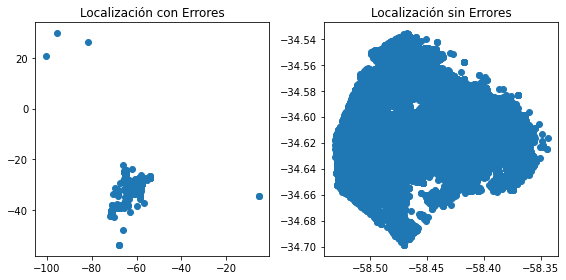

In [13]:
import json
path = "./metadata/provincia.json"
with open(path, "r", encoding="utf-8") as js: 
    js = json.load(js)


poligono_caba = [tuple(x) for x in js['features'][0]['geometry']['coordinates'][0][0]]

from geoBarrios import point_in_polygon

def is_caba(coord): 
    return(point_in_polygon(coord, poligono_caba))

data['is_caba'] = [is_caba((lon, lat)) for lon, lat in zip(data.lon, data.lat)]

print(f"Fueron {(data.is_caba==False).sum()} los casos en que la localización era externa a CABA")

data.loc[~data.is_caba, ['lon','lat']] = np.nan

fig, axs = plt.subplots(ncols=2, figsize=(8,4))

lon , lat = raw_df.lon , raw_df.lat #guardo la localización como vino del dataset
axs[0].scatter(lon,lat)
axs[0].set_title("Localización con Errores")

axs[1].scatter(data.lon,data.lat)
plt.title("Localización sin Errores")
plt.tight_layout()
plt.show()

2) Normalización datos barrios: dado que eran pocos casos se realizó una imputación manual sobre la columna `l3_cleaned`. Ej: Las Canitas ---> Palermo. Pompeya --> Nueva Pompeya. Abasto --> Almagro. Se realizó a groso modo, en un trabajo posterior debería ser revisado ya que hay casos como Once, Parque Centenario, que son zonas pertenecientes a una mezcla de barrios. 

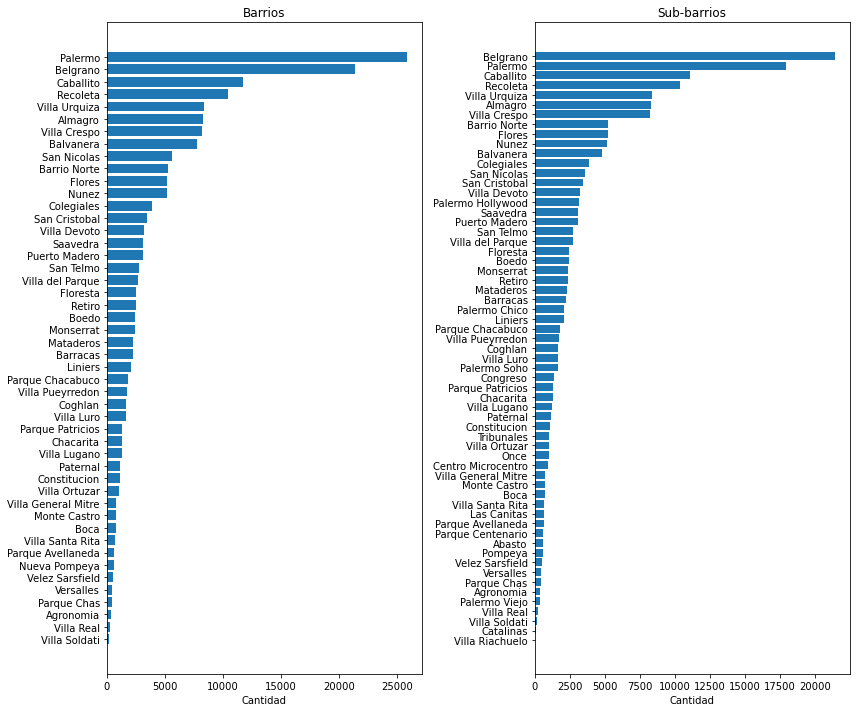

In [14]:
normalizador = {
    'Pompeya': 'Nueva Pompeya',
    'Las Canitas': 'Palermo',
    'Parque Centenario': 'Caballito', #Puede haber propiedades que en realidad pertenezcan a Almagro o Caballito
    'Centro Microcentro':'San Nicolas',
    'Tribunales':'San Nicolas',
    'Once':'Balvanera',  #puede haber propiedades que en realidd pertenezcan a Almagro.
    'Abasto':"Balvanera",  #puede haber propiedades que en realidad pertenezcan a Almagro. 
    "Catalinas":"Retiro", # la mayor parte de los casos caen ahí (algunos en Boca) 
    'Congreso':"Balvanera", #La mayor parte de los casos caen ahí (algunos en Belgrano)
    "Villa Riachuelo":"Villa Lugano", #Al ser pocas propiedades se imputó el barrio más próximo.
}

data['l3_norm'] = data.l3_cleaned.apply(lambda x: normalizador[x] if x in normalizador else x)
data['l4_nuevo'] = np.where(data.l4.isna()==False, data.l4, 
                            np.where(data.l3_cleaned != data.l3_norm, data.l3_cleaned, data.l3_norm)
                           ) #bieeeen Lucassss


gr1 = data.groupby("l3_norm")['id'].count().sort_values(ascending=False)

gr2 = data.groupby("l4_nuevo")['id'].count().sort_values(ascending=False)

fig, axs = plt.subplots(figsize = (12,10) , ncols=2)


barrios = gr1.index
cantidad1 = gr1.values

sub_barrios = gr2.index
cantidad2 = gr2.values

axs[0].barh(barrios, cantidad1, align='center')
axs[0].invert_yaxis()  # labels read top-to-bottom
axs[0].set_xlabel('Cantidad')
axs[0].set_title('Barrios')

axs[1].barh(sub_barrios, cantidad2, align='center')
axs[1].invert_yaxis()  # labels read top-to-bottom
axs[1].set_xlabel('Cantidad')
axs[1].set_title('Sub-barrios')

plt.tight_layout()
plt.show()

2) Si la latitud, longitud fueron NaN se completó con el promedio de las coordenadas del barrio, si para dicho registro el dato del barrio fue nulo entonces se quitó toda la fila. 

In [15]:
no_location = (data['lat'].isna()) & data['lon'].isna() & (data['l3_norm'].isna())
print(f"Fueron {no_location.sum()} los casos en que no habia locación")
data = data[~no_location].reset_index(drop=True)

Fueron 1758 los casos en que no habia locación


Para aquellas propiedades que sí tienen el barrio, pero no las coordenadas geográficas,se imputó con el promedio barrial de las coordenadas geográficas presentes en el dataset. 

In [16]:
lat_lon_barrios = data.groupby('l4_nuevo')[['lat', 'lon']].mean().reset_index()
lat_lon_barrios.columns = ['l4_nuevo','lat_barrio', 'lon_barrio']

data = pd.merge(data, lat_lon_barrios, how="left", left_on='l4_nuevo', right_on = 'l4_nuevo')

data['lat'] = np.where(data['lat'].isna(), data['lat_barrio'], data['lat'])
data['lon'] = np.where(data['lon'].isna(), data['lon_barrio'], data['lon'])

3) Luego de este procesamiento si el barrio fue nulo entonces se imputó el barrio correspondiente a la coordenada.

In [17]:
from geoBarrios import geoBarrios, coord_to_nbhd
barrios_dict = geoBarrios()
print(f"Un total de {data.l4_nuevo.isna().sum()} casos poseían barrio nulo y se les imputo el barrio correspondiente a la coordenada") 
data.loc[data.l4_nuevo.isna(), "l4_nuevo"] = data[data.l4_nuevo.isna()].apply(lambda row: coord_to_nbhd(coord=(row.lon,row.lat),polygons_dict=barrios_dict), axis=1).values
data.loc[data.l3_norm.isna(), "l3_norm"] = data[data.l3_norm.isna()].apply(lambda row: coord_to_nbhd(coord=(row.lon,row.lat),polygons_dict=barrios_dict), axis=1).values

Un total de 89 casos poseían barrio nulo y se les imputo el barrio correspondiente a la coordenada


In [18]:
data.drop(columns = ["l3","l3_cleaned","l4","is_caba","lat_barrio","lon_barrio"], inplace=True)

In [19]:
data.isna().sum()

id                         0
start_date                 0
end_date                   0
lat                        0
lon                        0
rooms                  27155
bedrooms               49130
bathrooms              24285
surface_total          60449
surface_covered        61934
price                   3245
currency                3517
title                      0
description                0
property_type              0
title_cleaned              0
description_cleaned        0
l3_norm                    0
l4_nuevo                   0
dtype: int64

Pendiente para un próximo abordaje: 

* Para los casos en que la localización era externa a CABA y el barrio no nulo, se imputó un punto centroide del barrio. Eso pudo conducir a errores dado que implícitamente se "confía" en que el dato del barrio fue correcto. Una alternativa sería probar adicionalmente si de la columna `description_cleaned` fuera posible confirmar que no se tratase de casos que efectivamente pertenecieran a localizaciones externas a CABA. 
* Si el barrio y la localización no son nulos pero sí incongruentes (localización pertence a otro barrio) se procedío a imputar el punto centroide del barrio. . 

In [20]:
data.shape

(182052, 19)

## Trabajo sobre las variables: superficie total, superficie cubierta, ambientes, dormitorios y precio

#### Exploración de valores nulos

In [21]:
cols = ["surface_total","surface_covered","rooms","bedrooms", "price"]
(data[cols].isna().sum()/len(data)).apply(lambda x: "{:.2%}".format(x))

surface_total      33.20%
surface_covered    34.02%
rooms              14.92%
bedrooms           26.99%
price               1.78%
dtype: object

Es interesante evaluar los valores nulos las columnas `rooms` y `bedrooms`, según el tipo de propiedad. 

In [22]:
100*(data[['rooms','bedrooms']].isnull()==False).groupby(data['property_type']).sum().div(data.groupby("property_type")['rooms','bedrooms'].apply(lambda gr: len(gr)), axis=0) 

<ipython-input-22-d03bc979027a>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  100*(data[['rooms','bedrooms']].isnull()==False).groupby(data['property_type']).sum().div(data.groupby("property_type")['rooms','bedrooms'].apply(lambda gr: len(gr)), axis=0)


,rooms,bedrooms
property_type,,
Casa,79.558681,75.666828
Casa de campo,100.000000,100.000000
Cochera,45.767298,18.380363
Departamento,95.316431,82.363424
Depósito,19.508868,12.687585
Local comercial,28.666064,9.756098
Lote,17.841187,10.260845
Oficina,39.539677,19.872896
Otro,34.277620,31.232295


* Las columnas `rooms` y `bedrooms` poseen muchos nulos siempre que los avisos se traten de cocheras, depósitos, locales comerciales, lotes, oficinas, otros. Para las propiedades utilizadas como vivienda en cambio la presencia de nulos es mucho menor. Por ende en los casos en que las propiedades no sean para vivienda los nulos se completan con valor 0. 
* Luego de esto dada la alta correlación entre `surface_total` y `surface_covered` y entre `rooms` y `bedrooms`, para los casos en que el par tuviera datos nulos se procedió a eliminar la fila ante la dificultad para imputar nulos en esos casos. 
* Para la variable `price` se eliminaron las filas que tenían nulos ya que por ser la variable sobre la cual se constuirá la variable respuesta se decidió no realizar imputación de valores faltantes sobre la misma. 

#### Exploración de variables

* `surface_total < surface_covered`

In [23]:
data.surface_total.describe()

count    121603.000000
mean        158.710287
std        1199.568251
min          10.000000
25%          45.000000
50%          70.000000
75%         125.000000
max      140380.000000
Name: surface_total, dtype: float64

In [24]:
(data.surface_total < data.surface_covered).sum() 

899

* outliers en `surface_covered`

In [25]:
data.surface_covered.describe()

count    120118.000000
mean        139.283538
std        1388.575531
min           1.000000
25%          41.000000
50%          60.000000
75%         102.000000
max      170000.000000
Name: surface_covered, dtype: float64

* `rooms < bedrooms`

In [26]:
(data.rooms < data.bedrooms).sum() 

575

* outliers en `rooms`

In [27]:
data.rooms.describe()

count    154897.000000
mean          2.705391
std           1.519138
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          40.000000
Name: rooms, dtype: float64

* outliers en `bedrooms`

In [28]:
data.bedrooms.describe()

count    132922.000000
mean          1.979191
std           2.331642
min          -2.000000
25%           1.000000
50%           2.000000
75%           3.000000
max         286.000000
Name: bedrooms, dtype: float64

In [29]:
data.isnull().sum()

id                         0
start_date                 0
end_date                   0
lat                        0
lon                        0
rooms                  27155
bedrooms               49130
bathrooms              24285
surface_total          60449
surface_covered        61934
price                   3245
currency                3517
title                      0
description                0
property_type              0
title_cleaned              0
description_cleaned        0
l3_norm                    0
l4_nuevo                   0
dtype: int64

In [30]:
data.shape

(182052, 19)

#### Procesamiento realizado

0) Imputar 0 en las columnas `['rooms','bedrooms']` cuando se trate de cocheras, depósitos, locales comerciales, lotes, oficinas, otros. 
1) Borrar filas donde los pares de columnas `['rooms','bedrooms']` o `['surface_total','surface_covered']` contengan nulos. 
2) Intercambiar los valores de las columnas cuando `rooms < bedrooms` o `surface_total < surface_covered`. 
3) Eliminar filas donde `price` sea nulo. 
4) Si para una fila uno de los valores de `['surface_total', 'surface_covered']` contiene valor outlier y el otro no es outlier, se le imputó un `NaN` al dato outlier y se dejó dicho valor para ser imputado luego por método MICE. En caso que los dos valores fueran outliers o uno outlier y el otro `NaN` se borró la fila. 
5) Si para una fila uno de los valores de `['rooms', bedrooms']` contiene valor outlier y el otro no es outlier, se le imputó un `NaN` al dato outlier y se dejó dicho valor para ser imputado luego por método MICE. En caso que los dos valores fueran outliers o uno outlier y el otro `NaN` se borró la fila. 
6) Se borraron los valores outliers de `price`
7) Luego de estos pasos se procedió a imputar los valores nulos con el método multivariado MICE en las columnas `['rooms', bedrooms','surface_total','surface_covered']` utilizando también la variable `price` como predictor. 

Reemplazar rooms y bedrooms 0 para property_type 'Local comercial', 'Depósito', 'Cochera', 'Lote', 'Oficina', 'Otro'

In [31]:
data.loc[data.property_type.isin(["Cochera","Depósito","Local comercial","Lote","Oficina","Otro"]),["rooms","bedrooms"]] = data.loc[data.property_type.isin(["Cochera","Depósito","Local comercial","Lote","Oficina","Otro"]),["rooms","bedrooms"]].fillna(0)

In [32]:
data.shape

(182052, 19)

In [45]:
nas_rb = data[data[['rooms', 'bedrooms']].isna().any(axis=1)][['rooms', 'bedrooms', 'l3_norm']].groupby('l3_norm').count()

,rooms,bedrooms
l3_norm,,
Agronomia,57,24
Almagro,1244,203
Balvanera,963,165
Barracas,273,107
Barrio Norte,526,50
Belgrano,1925,321
Boca,79,44
Boedo,324,56
Caballito,1404,368


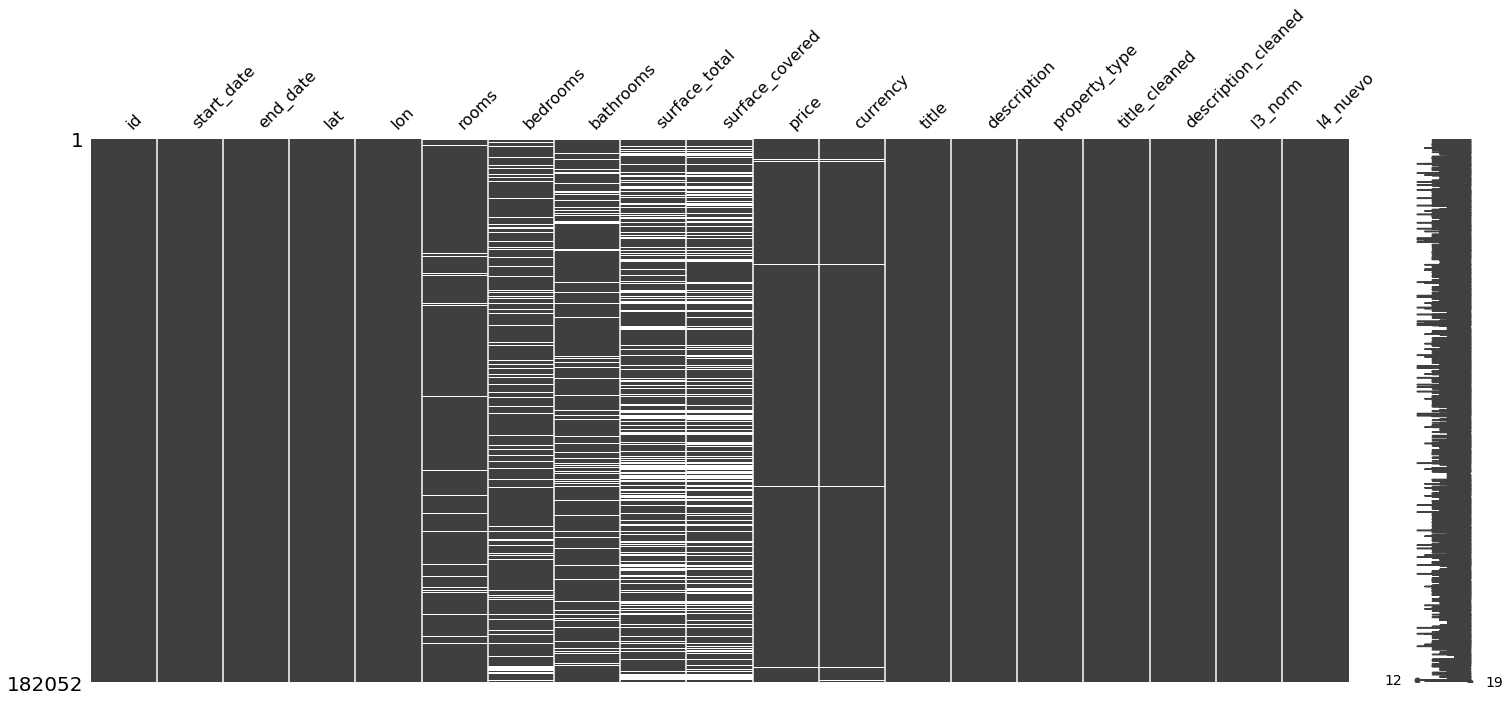

In [51]:
import missingno as msno

msno.matrix(data)

In [54]:
#punto 1
data.dropna(subset = ['rooms', 'bedrooms'], how = 'all', inplace = True)
data.shape


(177882, 19)

In [55]:
data.dropna(subset = ['surface_total', 'surface_covered'], how = 'all', inplace=True)
data.shape

(125225, 19)

In [ ]:
data.dropna(subset =['price'], inplace=True)
data.shape

In [ ]:
data.isnull().sum()

In [ ]:
data[['rooms','bedrooms']].isnull().groupby(data['property_type']).sum()

* outlieres en `surface_total`

In [ ]:
#punto 2
idx = data[data.surface_total<data.surface_covered].index
data.loc[idx,['surface_total','surface_covered']] = data.loc[idx,['surface_covered','surface_total']].values

idx = data[data.rooms<data.bedrooms].index
data.loc[idx,['rooms','bedrooms']] = data.loc[idx,['bedrooms','rooms']].values

4) Si para una fila uno de los valores de ['surface_total', 'surface_covered'] contiene valor outlier y el otro no es outlier, se le imputó un NaN al dato outlier y se dejó dicho valor para ser imputado luego por método MICE.

In [ ]:
#Generamos quantiles .01 y .99 para surface_total
data_st = data[['l3_norm', 'property_type', 'surface_total', 'rooms']]
data_st_q99 = data_st.groupby(['l3_norm', 'property_type', 'rooms']).quantile(.99)
data_st_q99.rename(columns = {'surface_total':'p99_surface_total'}, inplace = True)

data_sc = data[['l3_norm', 'property_type', 'surface_covered', 'rooms']]
data_sc_q99 = data_sc.groupby(['l3_norm', 'property_type', 'rooms']).quantile(.99)
data_sc_q99.rename(columns = {'surface_covered':'p99_surface_covered'}, inplace = True)

In [ ]:
data = data.merge(data_st_q99, how = "left", on = (['l3_norm', 'property_type', 'rooms']))
data = data.merge(data_sc_q99, how = "left", on = (['l3_norm', 'property_type', 'rooms']))

In [ ]:
##Generamos quantiles .01 y .99 para surface_covered
data_st_q01 = data_st.groupby(['l3_norm', 'property_type', 'rooms']).quantile(.01)
data_st_q01.rename(columns = {'surface_total':'p01_surface_total'}, inplace = True)

data_sc_q01 = data_sc.groupby(['l3_norm', 'property_type', 'rooms']).quantile(.01)
data_sc_q01.rename(columns = {'surface_covered':'p01_surface_covered'}, inplace = True)

In [ ]:
data = data.merge(data_st_q01, how = "left", on = (['l3_norm', 'property_type', 'rooms']))
data = data.merge(data_sc_q01, how = "left", on = (['l3_norm', 'property_type', 'rooms']))

In [ ]:
# Registros con un outlier en surface_total
data[(data['surface_total'] > data['p99_surface_total']) | (data['surface_total'] < data['p01_surface_total'])]

In [ ]:
# Registros con un outlier en surface_covered
data[(data['surface_covered'] > data['p99_surface_covered']) | (data['surface_covered'] < data['p01_surface_covered'])]

In [ ]:
#Elimino registros con 2 precios outliers
data = data[(data['surface_total'] < data['p99_surface_total']) & (data['surface_total'] > data['p01_surface_total']) & (data['surface_covered'] < data['p99_surface_covered']) & (data['surface_covered'] > data['p01_surface_covered'])]

In [ ]:
# Registros con un outlier en surface_covered
data[(data['surface_covered'] > data['p99_surface_covered']) | (data['surface_covered'] < data['p01_surface_covered'])]

In [ ]:
# Registros con un outlier en surface_total
data[(data['surface_total'] > data['p99_surface_total']) | (data['surface_total'] < data['p01_surface_total'])]

In [ ]:
#Paso a NA el registro outlier de surface_total o surface_covered
data['surface_total'] = np.where((data['surface_total'] > data['p99_surface_total']) | (data['surface_total'] < data['p01_surface_total']), np.nan, data['surface_total'])
data['surface_covered'] = np.where((data['surface_covered'] > data['p99_surface_covered']) | (data['surface_covered'] < data['p01_surface_covered']), np.nan, data['surface_covered'])
#Dropeo columnas accesorias
data = data.drop(['p99_surface_total', 'p01_surface_total', 'p99_surface_covered', 'p01_surface_total'], axis = 1)

In [ ]:
data.isnull().sum()

In [ ]:
data.shape

En caso que los dos valores de 'surface_covered' y 'surface_total' fueran outliers o uno outlier y el otro NaN se borró la fila

In [ ]:
data = data.dropna(subset=['surface_covered', 'surface_total'], how='all')

In [ ]:
data.shape

 5) Si para una fila uno de los valores de ['rooms', bedrooms'] contiene valor outlier y el otro no es outlier, se le imputó un NaN al dato outlier y se dejó dicho valor para ser imputado luego por método MICE. En caso que los dos valores fueran outliers o uno outlier y el otro NaN se borró la fila.

PENDIENTE

In [ ]:
outliers_rooms = data[['l3_norm', 'property_type', 'surface_total', 'rooms']]
outliers_sup_rooms = outliers_rooms.groupby(['l3_norm', 'property_type']).quantile(.9)
outliers_sup_rooms.sort_values(by=['rooms'])

In [ ]:
outliers_bedrooms = data[['l3_norm', 'property_type', 'surface_total', 'bedrooms']]
outliers_sup_bedrooms = outliers_bedrooms.groupby(['l3_norm', 'property_type']).quantile(.9)
outliers_sup_bedrooms.sort_values(by=['bedrooms'])

 6) Se borraron los valores outliers de price agrupados por barrio, tipo de propiedad y cuartos

In [ ]:
data.shape

In [ ]:
data_pr = data[['l3_norm', 'property_type', 'price', 'rooms']]
data_pr_q99 = data_pr.groupby(['l3_norm', 'property_type', 'rooms']).quantile(.99)
data_pr_q99.rename(columns = {'price':'p99_price'}, inplace = True)
data_pr_q01 = data_pr.groupby(['l3_norm', 'property_type', 'rooms']).quantile(.01)
data_pr_q01.rename(columns = {'price':'p01_price'}, inplace = True)
data = data.merge(data_pr_q99, how = "left", on = (['l3_norm', 'property_type', 'rooms']))
data = data.merge(data_pr_q01, how = "left", on = (['l3_norm', 'property_type', 'rooms']))
#Eliminamos precios outliers
data = data[(data['price']< data['p99_price']) & (data['price'] > data['p01_price'])]

In [ ]:
data.shape

In [ ]:
data.isnull().sum()

7) Luego de estos pasos se procedió a imputar los valores nulos con el método multivariado MICE en las columnas ['rooms', bedrooms','surface_total','surface_covered'] utilizando también la variable price como predictor.

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
data[data[['l3_norm', 'property_type', 'rooms', 'bedrooms', 'surface_total', 'surface_covered']].isna().any(axis=1)][['l3_norm', 'property_type', 'rooms', 'bedrooms', 'surface_total', 'surface_covered']]

In [ ]:
data[data[['l3_norm', 'property_type', 'rooms', 'bathrooms', 'surface_total', 'surface_covered']].isna().any(axis=1)][['l3_norm', 'property_type', 'rooms', 'bedrooms', 'surface_total', 'surface_covered']]

In [ ]:
imp = IterativeImputer(max_iter=10, random_state=0)  # tiene add_indicator
imp.fit_transform(df[['l3_norm', 'property_type', 'rooms', 'bathrooms', 'surface_total', 'surface_covered']])

## Modificación de los tipos de datos

Acá hay que señalar si se realizaron cambios en los tipos de datos: ejemplo todas las variables que se pasan a categoricas para mejorar el uso de memoria que realiza pandas. 

## Resultados Pre-procesamiento. 

Enumerar cantidad de filas y columnas iniciales, enumerar cantidad de filas y columnas resultantes. 

### Columnas

Columnas iniciales: 

In [56]:
raw_df.columns

Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon',
       'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price', 'currency', 'price_period',
       'title', 'description', 'property_type', 'operation_type'],
      dtype='object')

Columnas a exportar por este script:

In [57]:
data.columns

Index(['id', 'start_date', 'end_date', 'lat', 'lon', 'rooms', 'bedrooms',
       'bathrooms', 'surface_total', 'surface_covered', 'price', 'currency',
       'title', 'description', 'property_type', 'title_cleaned',
       'description_cleaned', 'l3_norm', 'l4_nuevo'],
      dtype='object')

### Filas

#### Imputación de datos faltantes

#### Registros iniciales y finales

Filas iniciales:

In [60]:
len(raw_df)

183810

In [ ]:
Filas a exportar por este script:

In [61]:
len(data)

125225

## Exportación

Este csv es recuperado por el script de Feature Engineering para generar variables adicionales 

In [ ]:
data.to_csv('resultados/cabaventa_preproc.csv')